<a href="https://colab.research.google.com/github/jwinding/object_detection_study/blob/master/deep_conv_net_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a somewhat deep network with convolutional layers on CIFAR-10

In this notebook I implement a vgg-11 network (roughly following the seminal work https://arxiv.org/pdf/1409.1556.pdf ), and train it on the CIFAR-10 dataset, achieving something like 98% validation accuracy. This is of course a bit like killing a mosquito with a nuke, but this was just a short learning excersize for me to familiarize myself with image classification basics. My next goal is to understand and implement the SSD-net architecture for object detection and localization. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
import tensorflow_datasets as tfds
keras = tf.keras 

In [0]:
import os
import pickle

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, History

# Define the Model
First, let's define a neural network, using convolutional layers, maxpooling, and lastly some fully connected layers with heavy dropout. This is basically the architecture presented in https://arxiv.org/pdf/1409.1556.pdf , but a bit shallower, since the CIFAR-10 dataset I'm training on is a lot smaller than ImageNet. Since the images are lower resolution, one also has to start with fewer filters in the conv2d layers, since using too many filters to start completely messes up the networks ability to extract any meaningful features. 


In [0]:
# things describing the data we will use; in this case the CIFAR-10 dataset. 

NUM_CLASSES = 10  #number of classes we want to classify
l2_reg = 0.0005



# creating all the layers before adding them to the model. I create more layers
# than I eventually use; mimicking the Vgg-16 model. 
conv1_1 = Conv2D(filters=16, kernel_size=(3,3),
                 activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv1_1')
conv1_2 = Conv2D(16, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal', 
                 kernel_regularizer=l2(l2_reg),
                 name='conv1_2')
maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',
                        name='pool1')

conv2_1 = Conv2D(32, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv2_1')
conv2_2 = Conv2D(32, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv2_2')
maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',
                        name='pool2')


conv3_1 = Conv2D(64, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv3_1')
conv3_2 = Conv2D(64, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv3_2')
conv3_3 = Conv2D(64, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv3_3')
maxpool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',
                        name='pool3')

conv4_1 = Conv2D(128, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv4_1')
conv4_2 = Conv2D(128, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv4_2')
conv4_3 = Conv2D(128, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv4_3')
maxpool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',
                        name='pool4')

conv5_1 = Conv2D(256, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv5_1')
conv5_2 = Conv2D(256, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv5_2')
conv5_3 = Conv2D(256, (3,3), activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(l2_reg),
                 name='conv5_3')
maxpool5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same',
                        name='pool5')

fc6 = Dense(units = 512,  activation='relu', 
            kernel_initializer='he_normal',
            kernel_regularizer=l2(l2_reg),
                 name='fc6')
dropout1 = Dropout(0.5, name="dropout1")

fc7 = Dense(512,  activation='relu', 
            kernel_initializer='he_normal', 
            kernel_regularizer=l2(l2_reg),
            name='fc7')
dropout2 = Dropout(0.5, name="dropout2")

fc8 = Dense(NUM_CLASSES,  activation='softmax',
            kernel_initializer='he_normal', 
            kernel_regularizer=l2(l2_reg),
            name='fc8_out')

vgg_model_shallow = keras.Sequential([
     conv1_1, #conv1_2, maxpool1,
     conv2_1, #conv2_2, 
    maxpool2,
     conv3_1, #conv3_2, conv3_3, maxpool3,
     conv4_1, #conv4_2, conv4_3, 
    maxpool4,
    #conv5_1, #conv5_2, conv5_3, maxpool5,
    fc6, 
    dropout1,
    fc7,
    dropout2,
    Flatten(),
    fc8 
 ])


# Load the CIFAR dataset

I have the CIFAR dataset on my google drive, so first I mount it, then I write a small helper function to load the batches, which are in pickled form. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_path = '/content/gdrive/My Drive/Machine learning/CIFAR/cifar-10-batches-py'

In [0]:
# The 10 labels of the CIFAR-10 dateset is: 
label_strings = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(batch_id):
    with open(data_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [0]:
# collect the entire dataset into a single array, and a single arrays with the labels.
# this set is small enough that this can be done without exhausting the RAM. 
data = [] 
for i in range(6):
  data.append(load_cfar10_batch(1))

features = data[0][0]
labels = data[0][1]
for i in range(1,len(data)):
  features = np.append(features, data[i][0], axis=0)
  labels += data[i][1]
  
features.shape, len(labels)

((60000, 32, 32, 3), 60000)

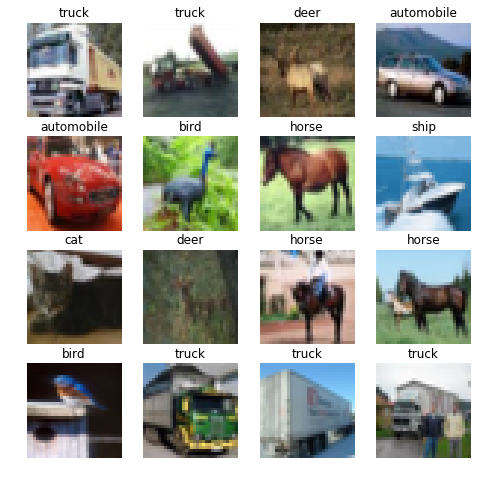

In [0]:
# Let's plot a few images to see that the loading went correctly,
# and to see how the dataset actually looks like. 
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = features[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_strings[labels[i]])
plt.show()


# Making the training data from the loaded images
Next, let's do some preprocessing of the images, to get them in a form suitable for a neural network. Essentially we just normalize each RGB channel so that they get mean 0 and standard deviation 1, using the StandardScaler from sci-kit learn. 
Then let's also use a built-in keras function to augment the data a little; essentially rotate, shear and so on, to create new, slightly different images from the original data. This acts as a further regularization, making the network more robust. 

In [0]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [0]:
x_train, x_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2)
x_train = x_train.astype(float)
x_test = x_test.astype(float)

In [0]:
x_train_s = np.zeros(x_train.shape)
x_test_s = np.zeros(x_test.shape)

scalers = {}
# Since the sklearn standard Scaler only works on 2d tensors, we have to scale each 
# channel of the images separately. This code does that, training the scaler on 
# the training data, and then applying it to the test. 
for i in range(x_train.shape[3]):
    scalers[i] = preprocessing.StandardScaler()
    temp = scalers[i].fit_transform(x_train[:,:,:,i].reshape((x_train.shape[0],-1)))
    x_train_s[:,:,:,i] = temp.reshape(x_train.shape[:3])

for i in range(x_test.shape[3]):
    temp = scalers[i].fit_transform(x_test[:,:,:,i].reshape((x_test.shape[0],-1)))
    x_test_s[:,:,:,i] = temp.reshape(x_test.shape[:3])


In [0]:
#makes the y_train to 1-hot vectors using built-in keras function. 
y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
#this is the data augmentor, which will generate the data stream that we will train on. 
#It generates new images by rotating, zooming, shearing, shiftting the images just very slightly,
# and also horizontally flipping them. 
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=2, zoom_range=0.05,
	width_shift_range=0.02, height_shift_range=0.02, shear_range=0.015,
	horizontal_flip=True, fill_mode="nearest")


# Train the model
Sets up the optimizer, the Adam one, and compiles the model. I also add some callbacks to save the weights and also the history of the training for vizualization purposes. 

In [0]:
#Originally the vgg-net used stochastic gradient descent with momentum, but I think 
#the Adam optimizer is slightly better. 
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2 = 0.999,  epsilon=1e-8)

vgg_model_shallow.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
savepath= '/content/gdrive/My Drive/Machine learning/CIFAR/keras_shallow_vggstyle_model_tmp.h5'

checkpointer = ModelCheckpoint(filepath=savepath, verbose=1, save_best_only=True)
history = History()


In [0]:
BATCH_SIZE = 200
EPOCHS = 50

data_stream = aug.flow(x_train_s, y_train, batch_size=BATCH_SIZE)

vgg_model_shallow.fit_generator(data_stream, epochs = EPOCHS,
                        steps_per_epoch= x_train_s.shape[0] // BATCH_SIZE,
                        verbose = 1, validation_data=(x_test_s,y_test),
                        callbacks=[history, checkpointer])              

Epoch 1/50
239/240 [============================>.] - ETA: 0s - loss: 2.8759 - accuracy: 0.2676
Epoch 00001: val_loss improved from inf to 2.12870, saving model to /content/gdrive/My Drive/Machine learning/CIFAR/keras_shallow_vggstyle_model_tmp.h5
240/240 [==============================] - 42s 176ms/step - loss: 2.8724 - accuracy: 0.2686 - val_loss: 2.1287 - val_accuracy: 0.5336
Epoch 2/50
239/240 [============================>.] - ETA: 0s - loss: 1.8547 - accuracy: 0.5683
Epoch 00002: val_loss improved from 2.12870 to 1.54395, saving model to /content/gdrive/My Drive/Machine learning/CIFAR/keras_shallow_vggstyle_model_tmp.h5
240/240 [==============================] - 35s 147ms/step - loss: 1.8534 - accuracy: 0.5685 - val_loss: 1.5440 - val_accuracy: 0.6696
Epoch 3/50
239/240 [============================>.] - ETA: 0s - loss: 1.4695 - accuracy: 0.6725
Epoch 00003: val_loss improved from 1.54395 to 1.40882, saving model to /content/gdrive/My Drive/Machine learning/CIFAR/keras_shallow_vg

KeyboardInterrupt: ignored

In [0]:
#Save the final model to disk as well: 
savepath= '/content/gdrive/My Drive/Machine learning/CIFAR/keras_shallow_vggstyle_model.h5'
vgg_model_shallow.save(savepath)

So with this model, I got an validation accuracy of 98%, which seems pretty good. 

In [0]:
vgg_model_shallow.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             multiple                  448       
_________________________________________________________________
conv2_1 (Conv2D)             multiple                  4640      
_________________________________________________________________
pool2 (MaxPooling2D)         multiple                  0         
_________________________________________________________________
conv3_1 (Conv2D)             multiple                  18496     
_________________________________________________________________
conv4_1 (Conv2D)             multiple                  73856     
_________________________________________________________________
pool4 (MaxPooling2D)         multiple                  0         
_________________________________________________________________
fc6 (Dense)                  multiple                 

# Training visualization
We can finally use the History callback to have a look at how the training went.

The explanation why the validation accuracy is consistenly higher than the training one is probably because I'm using a dropout of 50%; which is applied during training but not during the validation phase. At least that's how I understand it: I guess one can test this by checking the behavior when using less or no dropout... 



In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

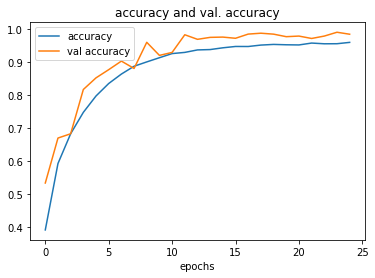

In [0]:
plt.plot(acc,label='accuracy')
plt.plot(val_acc,label='val accuracy')
plt.xlabel('epochs')
plt.title('accuracy and val. accuracy')
plt.legend()
plt.show()

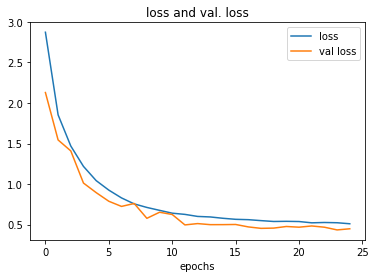

In [0]:
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val loss')
plt.xlabel('epochs')
plt.title('loss and val. loss')
plt.legend()
plt.show()